# Image classification
In this notebook we are solving an image classification problem using Convolutional neural net. 

The data we are goin to work with is the MNIST dataset which contains of 70000 numbers evenly distributed between 0-9.

The aim is to introduce the concept of convolutional layers and show the potential. The user shluld be familar with neural nets. This notebook is very similar to  a notebook solving the problem with a traditional densly coupled neural net.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from scipy import ndimage
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

from skimage import measure

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Run twice to close the annoying warning created by numpy and tensorflow

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          fig_size=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100
    else:
        cm = cm
    

    fig, ax = plt.subplots(figsize=(fig_size,fig_size))
    im = ax.imshow(cm,norm=LogNorm(), cmap=cmap,
                interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ylim=ax.get_ylim()
    ax.set(
        ylim=ylim,
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes, 
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_errors(x_test, y_test, output,n_max=600):
    """ Function the reporting in a script in order to
    breake the script if it is estimated to take to long time"""
    n_not_corr = np.sum(output != y_test )
    n = int(np.ceil(np.sqrt(n_not_corr)))
    j = 0
    if n_not_corr > n_max:
        print('more then '+str(n_max),n**2)
        return
    f, ax = plt.subplots(n, n, figsize=(25, 25))
    ax = ax.flatten()
    
    for i in range(np.shape(output)[0]):
            if output[i]!=y_test[i]:
                ax[j].set_title(str(y_test[i]) + ' as ' + str(output[i]))
                ax[j].imshow(x_test[i,:,:,0], cmap='gray')
                ax[j].axis('off')
                j+=1
    for x in ax.ravel():
        x.axis("off")
    plt.subplots_adjust(bottom=-0.09, wspace=0.03)
    plt.show()

c:\users\sjohanss\documents\utbildning\region västerbotten - ai - lab 4\test_env\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sjohanss\documents\utbildning\region västerbotten - ai - lab 4\test_env\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sjohanss\documents\utbildning\region västerbotten - ai - lab 4\test_env\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '

### Load the dataset
We also need to take a first look of the dataset by looking at the shape which gives us an idaea of the structure and size. We also show the dataset distribution.

Shape before reshape: (60000, 28, 28)
Train data: (60000, 28, 28, 1)
Test data: (10000, 28, 28, 1)


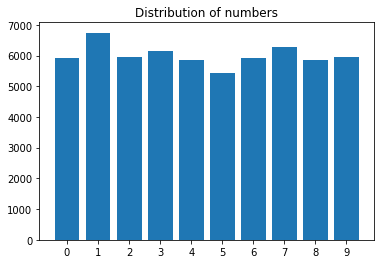

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Shape before reshape:',np.shape(x_train))
x_train = x_train.reshape(-1,28, 28, 1)   #Reshape for CNN !!
x_test = x_test.reshape(-1,28, 28, 1)     #The added dimension is to account for RRG images

##
print('Train data:',np.shape(x_train))
print('Test data:', np.shape(x_test))

y_count = np.bincount(y_train)
ii = np.nonzero(y_count)[0]
plt.bar(ii, y_count)
plt.xticks(ii)
plt.title('Distribution of numbers')
plt.show()


# Look at the dataset
It is always good to get a good overview of the dataset. In this case when images are going to be classified a good may to explore the dataset is by looking at the images. If you don't trust the dataset you should go through all images and see if the classification is correct. 

Remember that there is a huge job done preparing and classifying all images. If you are going to do a classification task youself you first need to classify a huge amount of images.

Note that some of the numbers are quite hard to classify even for the human eye. 

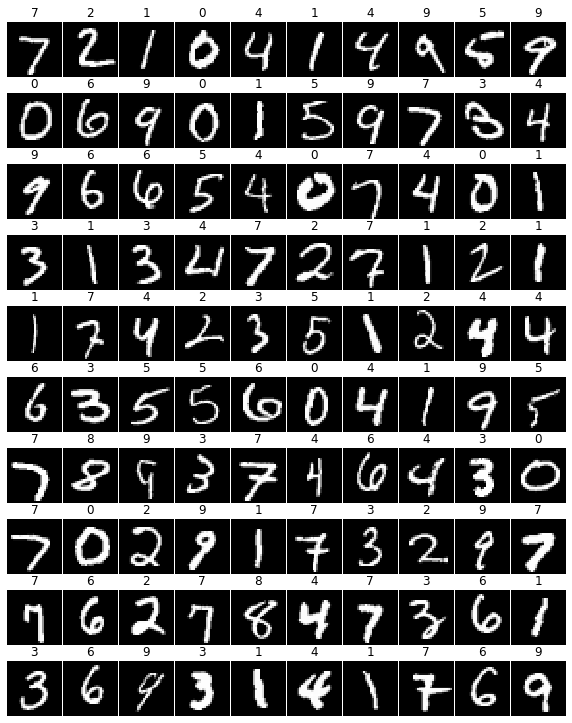

In [3]:
f, ax = plt.subplots(10, 10, figsize=(10, 10))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].imshow(x_test[i, :, :, 0], cmap='gray')
    ax[i].set_title(y_test[i])
[axi.set_axis_off() for axi in ax.ravel()]
plt.subplots_adjust(bottom=-0.09, wspace=0.03)
plt.show()

In [4]:
# Scale the dataset to have values between 0 and 1
if np.max(x_train)>1:
    x_train = x_train / 255.0
    x_test = x_test / 255.0
else:
    print('Already scaled once')

# Create the conv net
Instead of Densly coupled layers that only cares about each pixel. We try to make a more general network that tries to see more general characteristics of the image. 

In this first example we are using convolutional layers to "look" at 3x3 pixels and then reduce the size of the image with MaxPooling layer.



In [5]:
# Creating a Sequential Model and adding the layers
input_shape = (28, 28, 1) #The shape of each image
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dropout(0.1))
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.1))
model.add(Dense(10,activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])


### Look at the model
To get an idea of how many parameters we are trying to calculate. we can use the summary method. 


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 28)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1008)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1008)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               129152    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

### Calculation of parameters
In the first convolution layer there is only 280 parameters to calculate compared to the dens layer with over 600' parameters. In the convolution layer each filter is 3x3 hence 9 parameters is needed to describe the filter function. Additionally we have a bias for each filter then we have 28 filters in the convolutional layer. 
* (3 * 3 + 1) * 28 = 280


Before the dense layer we have flattened the resulting image of the convolutional layer. 
* 13 * 13 * 28 = 4732

Each neuron in the dense layer is connected to every neuron in the output of the previous layer resulting in:
*  (4732 + 1) * 128 = 605824

In the the classification layer there is 10 neurons, one for each class that are connected with the 128 output parameters. There is also one bias parameter for each node. 
* (28 + 1) * 10=290

In [8]:
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=256)
# model.evaluate(x_test, y_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 10s 172us/sample - loss: 0.2026 - acc: 0.9411 - val_loss: 0.1011 - val_acc: 0.9694
Epoch 2/2
60000/60000 [==============================] - 10s 171us/sample - loss: 0.1097 - acc: 0.9676 - val_loss: 0.0729 - val_acc: 0.9770


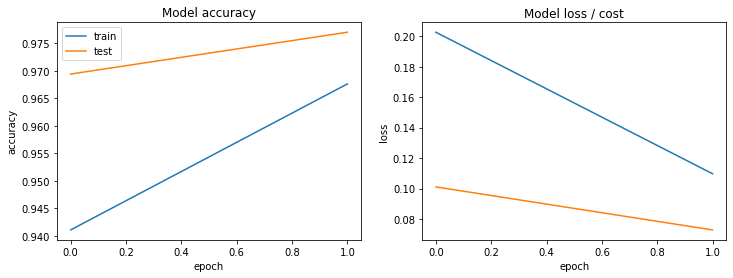

In [9]:
# summarize history for accuracy
f,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(history.history['acc'], label='train')
ax[0].plot(history.history['val_acc'], label='test')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()

# summarize history for loss
ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='test')
ax[1].set_title('Model loss / cost')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[0].legend()
plt.show()

In [10]:
prediction = model.predict_classes(x_test, verbose=1, batch_size=512)

10000/10000 [==============================] - 1s 58us/sample


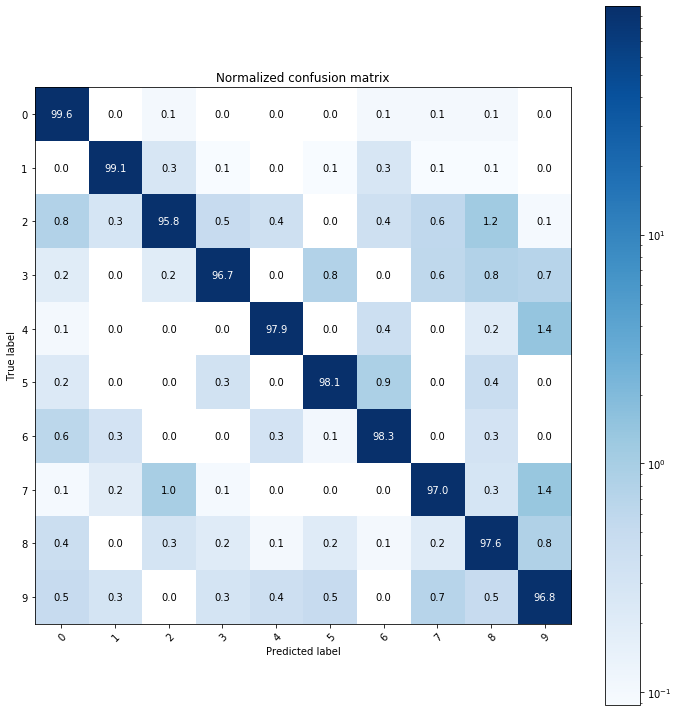

              precision    recall  f1-score   support

           0      0.971     0.996     0.983       980
           1      0.990     0.991     0.991      1135
           2      0.981     0.958     0.970      1032
           3      0.985     0.967     0.976      1010
           4      0.988     0.979     0.983       982
           5      0.981     0.981     0.981       892
           6      0.978     0.983     0.981       958
           7      0.977     0.970     0.974      1028
           8      0.961     0.976     0.968       974
           9      0.957     0.968     0.963      1009

    accuracy                          0.977     10000
   macro avg      0.977     0.977     0.977     10000
weighted avg      0.977     0.977     0.977     10000



In [12]:
class_names= np.unique(y_test)
plot_confusion_matrix(y_test, prediction, classes=class_names, normalize=True,
                      title='Normalized confusion matrix',fig_size=10)
plt.show()
print(classification_report(y_test, prediction, digits = 3))

### Discussion about the confusion matrix
Even though just two epochs was used to calculate classification model. It has come up with a rather good model. A very interesting observation in the confusion matrix above is that the model mixes numbers that are quite closesly looking for example 3 and 5, 7 and 2 and 4 and 9. It is quite easy to understand why and how those numbers can be confusing for the system.

### Investigate the errors
In the cell below all errors are plotted. In a lot of cases we can understand why the model predicted wrong. But in a lot of predictions we can expect the model to do better. 

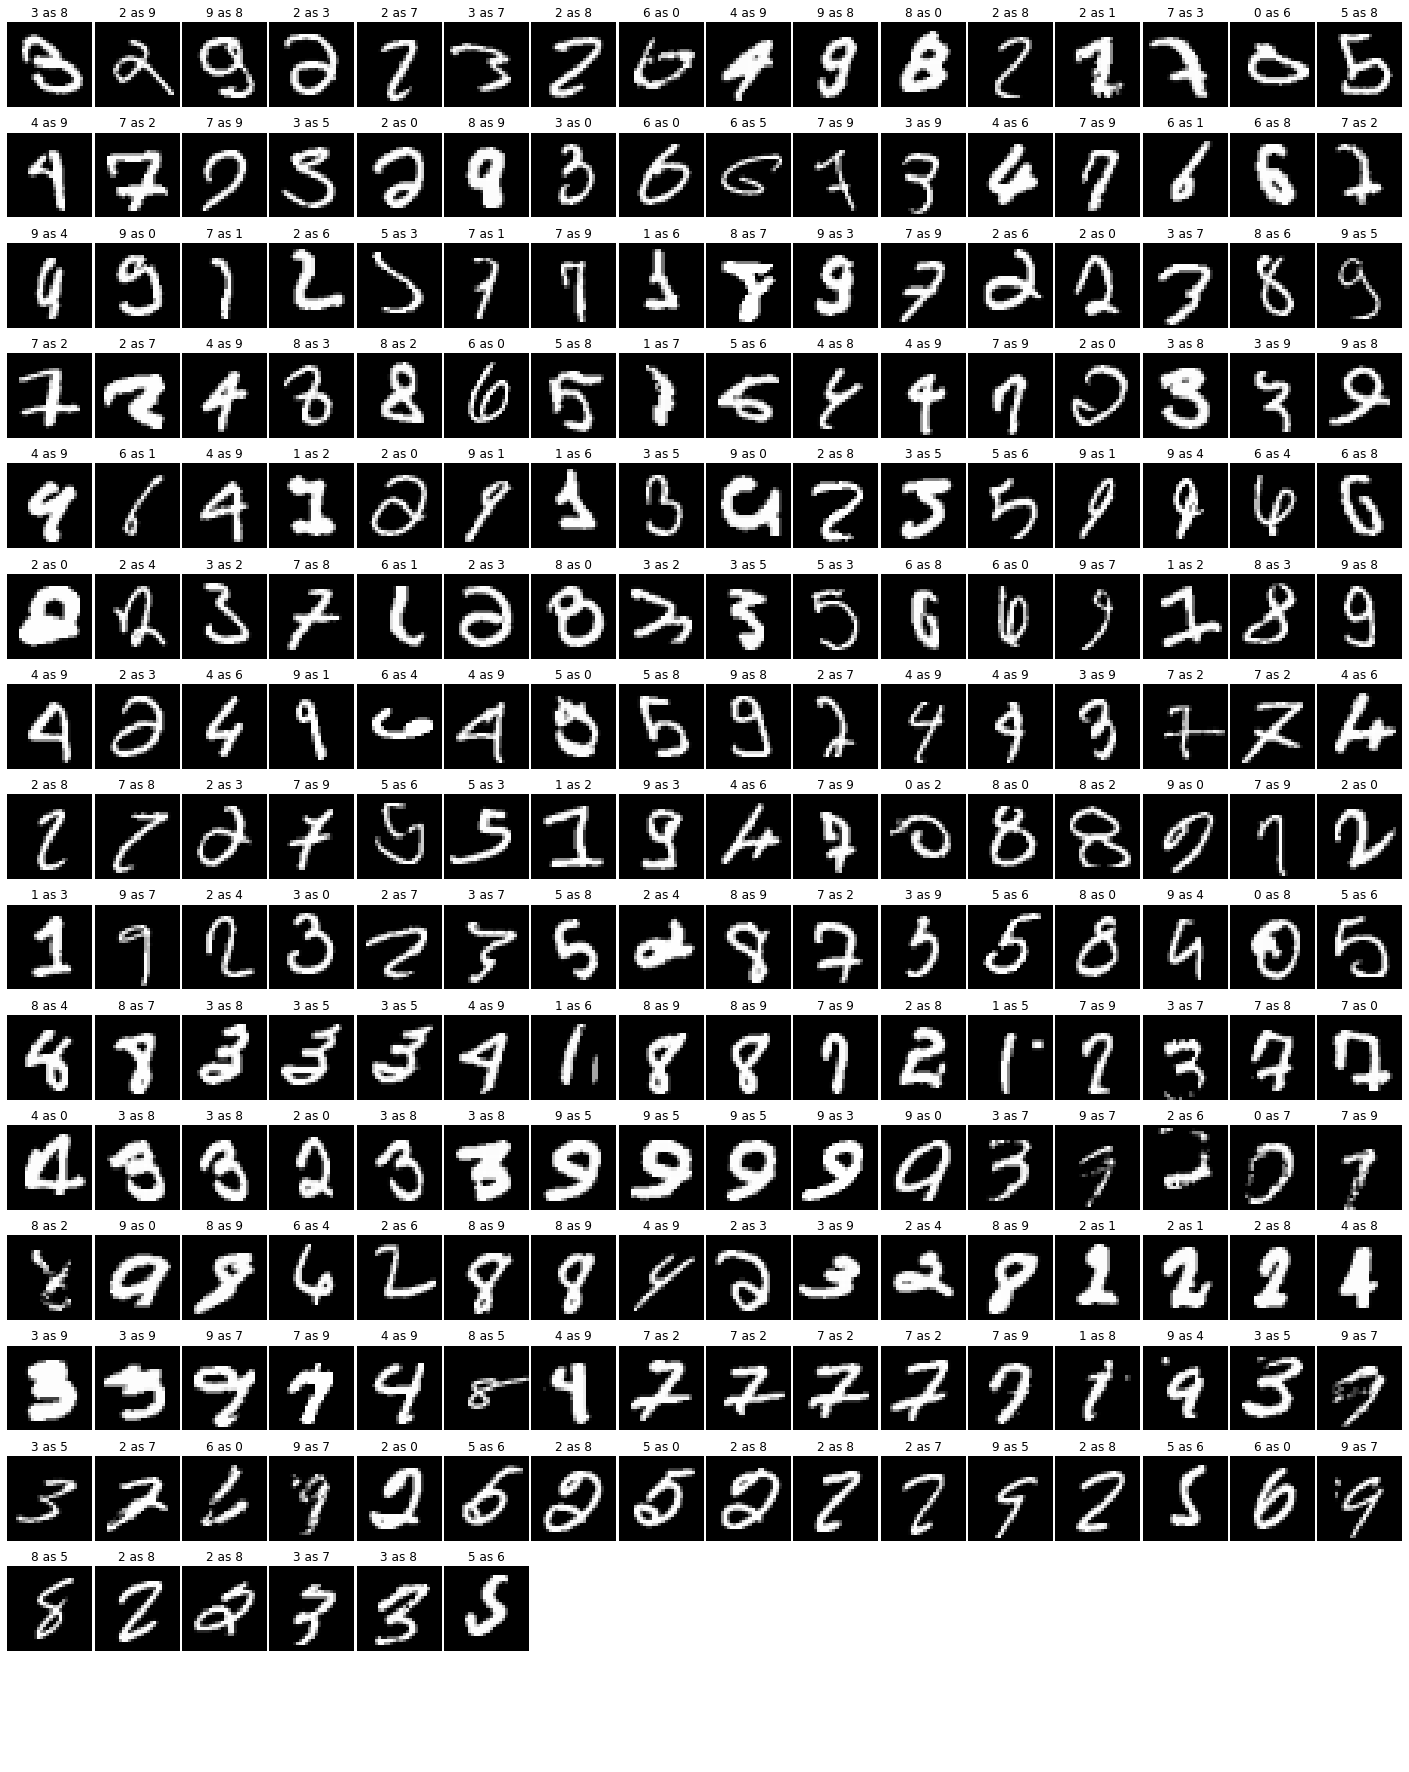

In [13]:
plot_errors(x_test, y_test, prediction, 600)

### Creating a slightly better model

In [14]:
# Creating a Sequential Model and adding the layers
input_shape = (28, 28, 1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Flattening the 2D arrays for fully connected layers
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.5))
model.add(Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [16]:
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=256)
model.evaluate(x_test, y_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 24s 401us/sample - loss: 0.1172 - acc: 0.9647 - val_loss: 0.0465 - val_acc: 0.9857
Epoch 2/2
10000/10000 [==============================] - 1s 133us/sample - loss: 0.0416 - acc: 0.9865


[0.0416392679709068, 0.9865]

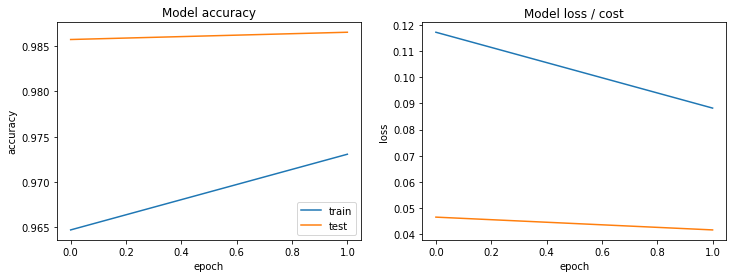

In [17]:
# summarize history for accuracy
f,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(history.history['acc'], label='train')
ax[0].plot(history.history['val_acc'], label='test')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()

# summarize history for loss
ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='test')
ax[1].set_title('Model loss / cost')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[0].legend()
plt.show()


# Evaluate the result
One way to evaluate the result is throug the confusion matrix. In the matrix below we cans see that twos that are predicted as something else is more likely to be predicted as a 7.

In [18]:
output = model.predict_classes(x_test, verbose=1, batch_size=512)

10000/10000 [==============================] - 1s 97us/sample


              precision    recall  f1-score   support

           0      0.970     0.996     0.983       980
           1      0.995     0.996     0.995      1135
           2      0.986     0.984     0.985      1032
           3      0.989     0.987     0.988      1010
           4      0.991     0.991     0.991       982
           5      0.993     0.979     0.986       892
           6      0.985     0.986     0.986       958
           7      0.983     0.982     0.983      1028
           8      0.983     0.980     0.982       974
           9      0.989     0.981     0.985      1009

    accuracy                          0.987     10000
   macro avg      0.986     0.986     0.986     10000
weighted avg      0.987     0.987     0.987     10000



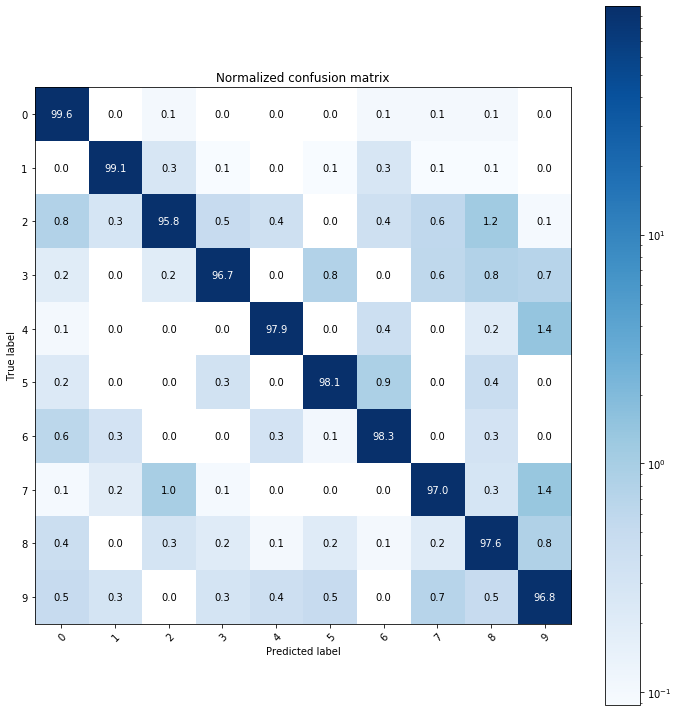

In [19]:
print(classification_report(y_test, output, digits = 3))
class_names= np.unique(y_test)#.astype(str)
plot_confusion_matrix(y_test, prediction, classes=class_names, normalize=True,
                      title='Normalized confusion matrix',fig_size=10)
plt.show()

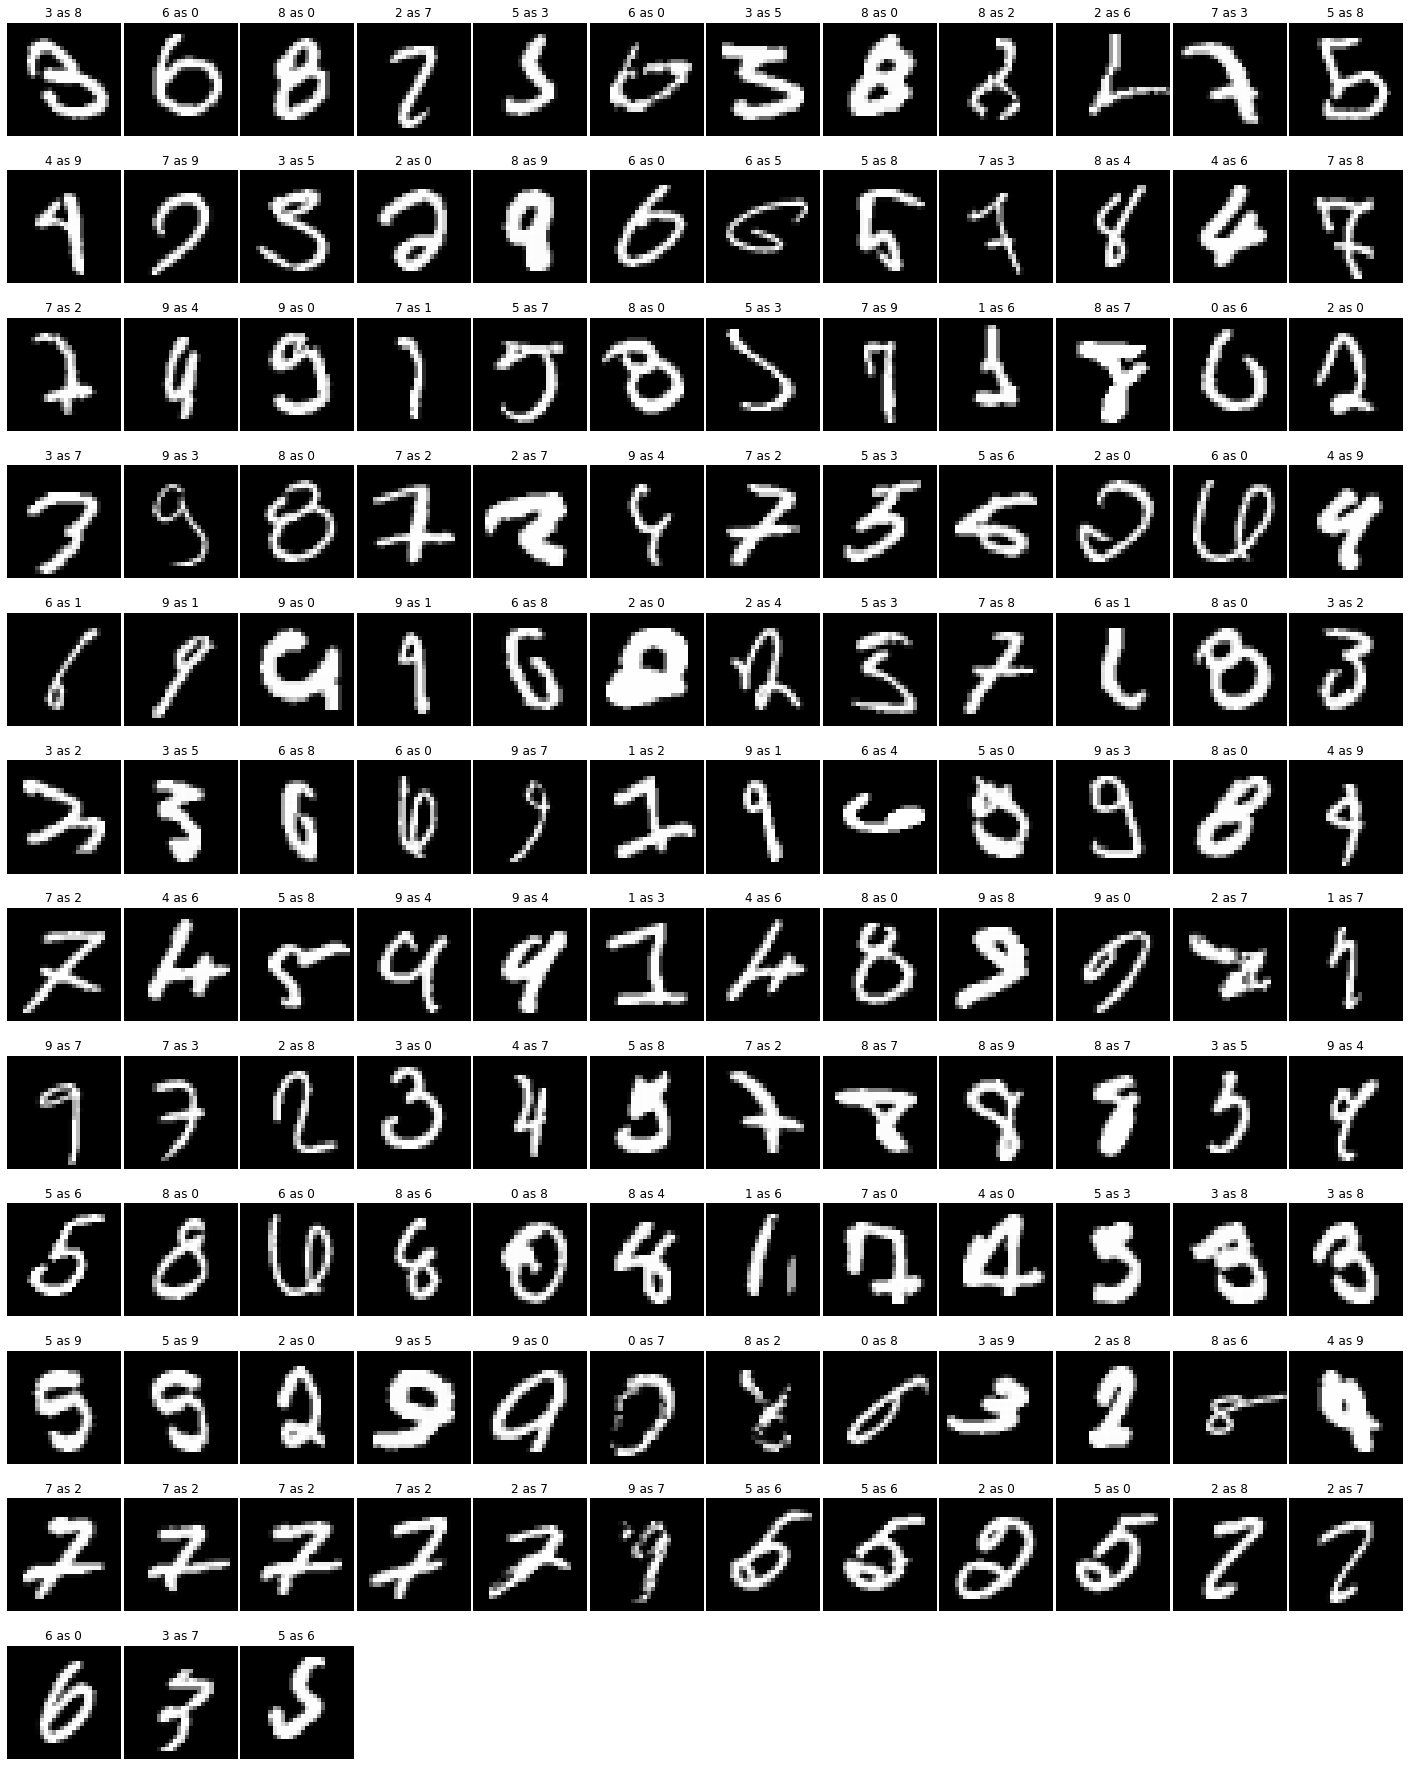

In [21]:
plot_errors(x_test, y_test, output, 600)

# Look at the filters/kernels
In the presentation there where a few slides about the filters. In this model we have used 3x3 filters and max poolinglayers

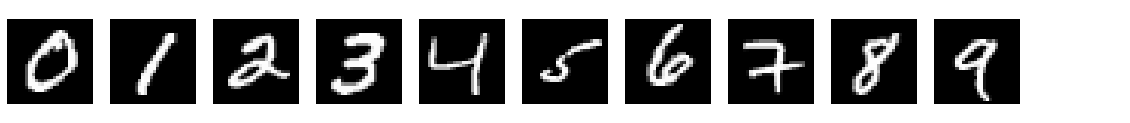

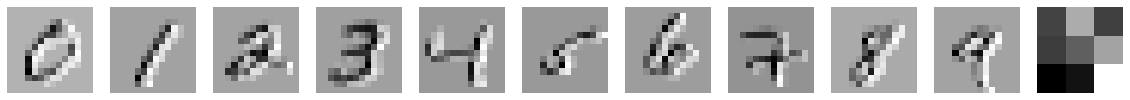

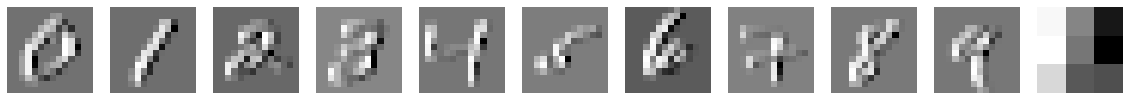

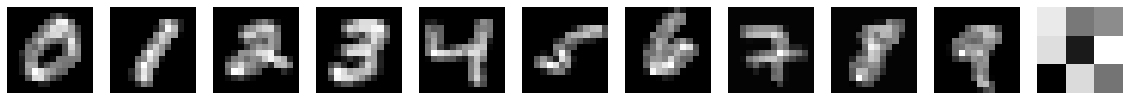

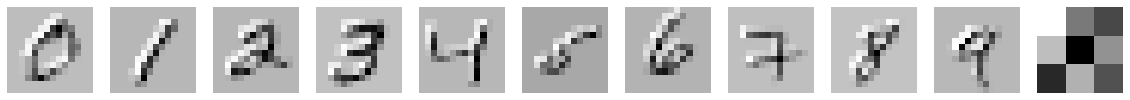

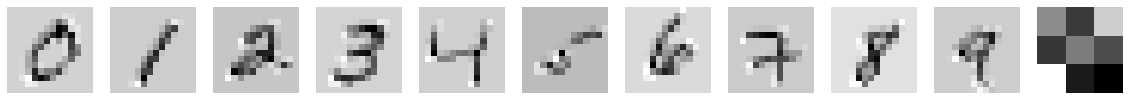

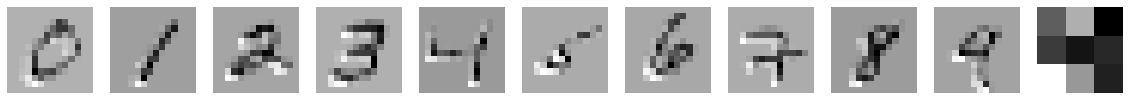

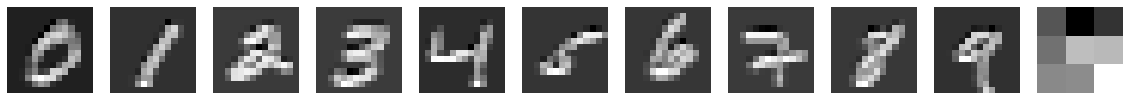

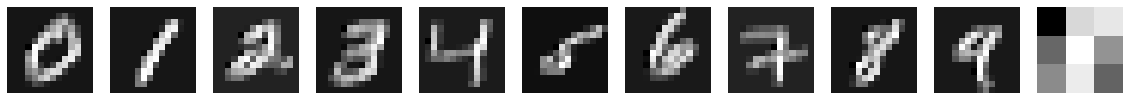

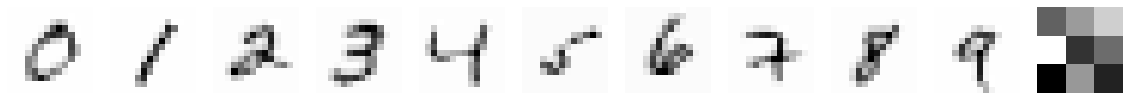

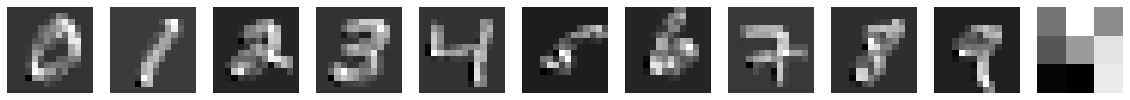

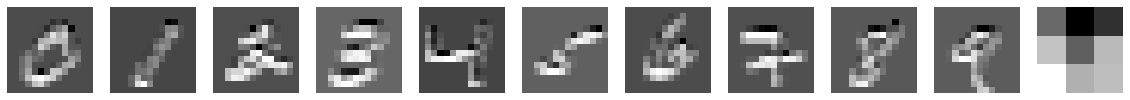

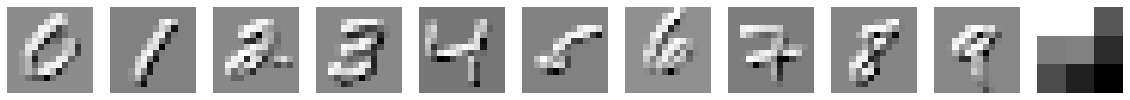

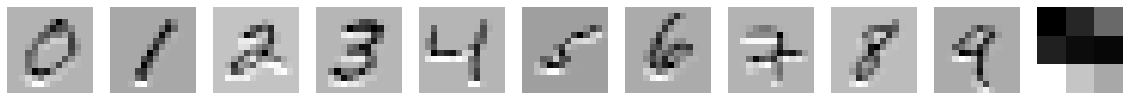

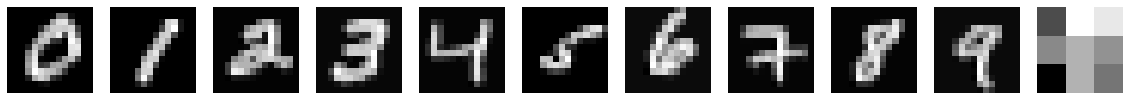

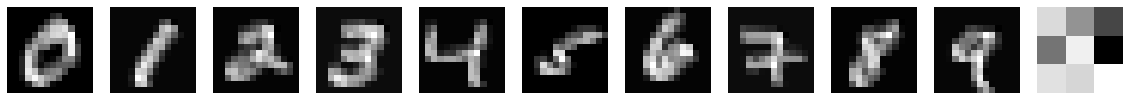

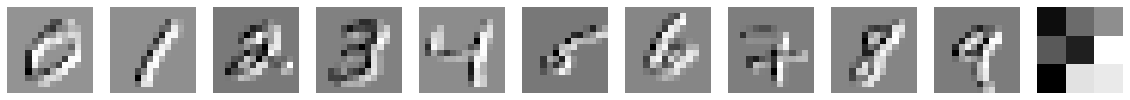

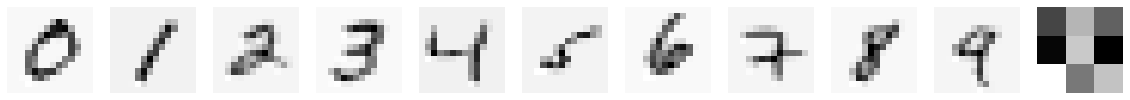

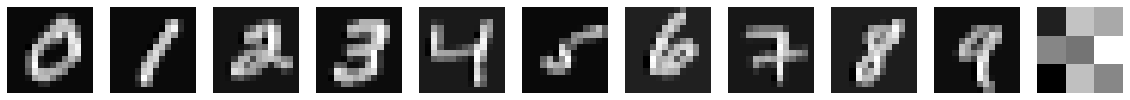

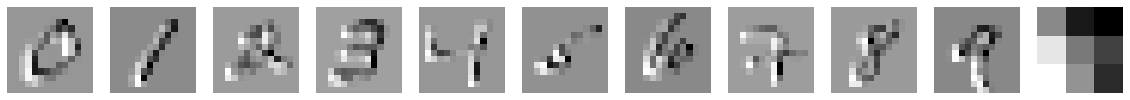

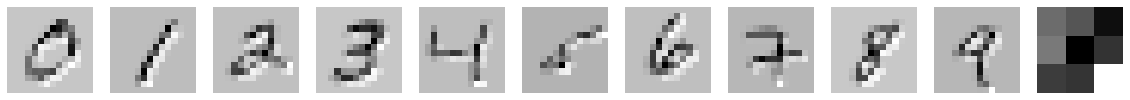

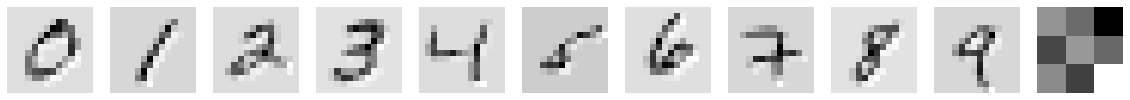

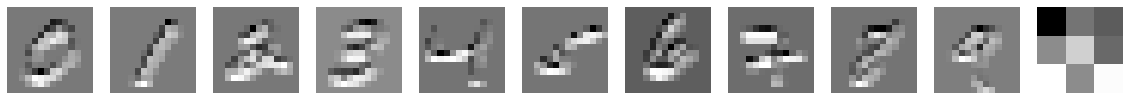

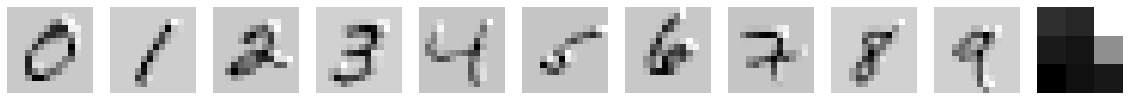

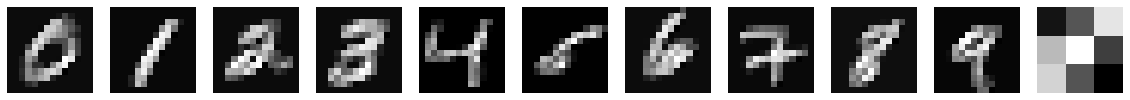

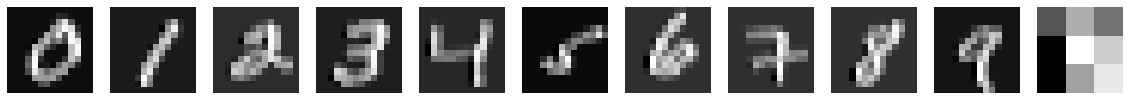

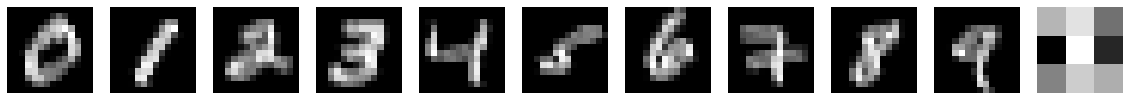

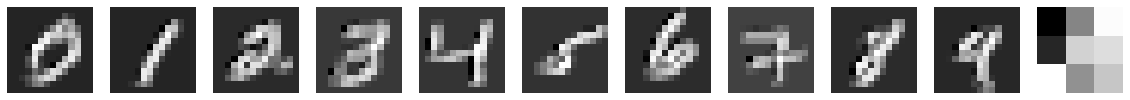

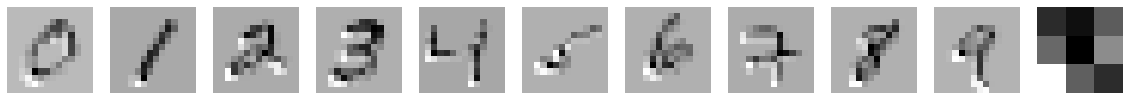

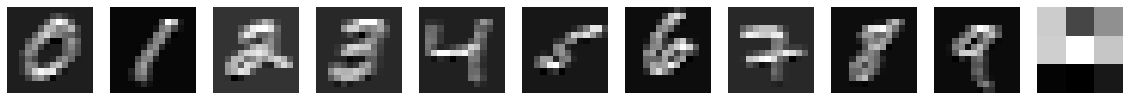

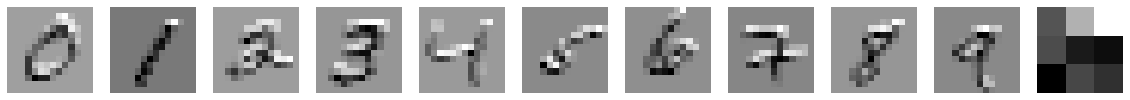

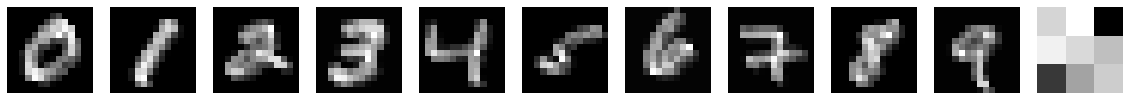

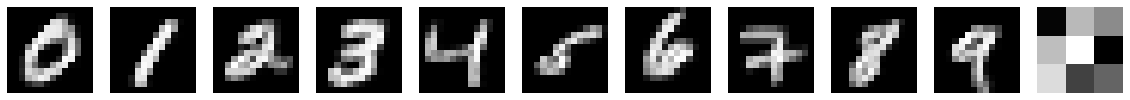

In [22]:
# First plot 
f,ax=plt.subplots(1,11,figsize=(20,2))
p=0
for j in [1,3,5,7,2,11,13,38,17,4]:
    im = x_train[j,:,:,0]
    ax[p].imshow(im,cmap='gray')
    p+=1
for i in range(11):
    ax[i].axis('off')
plt.show()

for i in range(np.shape(model.layers[0].get_weights()[0])[-1]):
    f,ax=plt.subplots(1,11,figsize=(20,2))
    p=0
    for j in [1,3,5,7,2,11,13,38,17,4]:
        im = x_train[j,:,:,0]
        k = model.layers[0].get_weights()[0][:,:,0,i]
        im = ndimage.convolve(im, k)
        im = measure.block_reduce(im, (2,2), np.max)
        
        ax[p].imshow(im,cmap='gray')
        p+=1
    ax[10].imshow(k,cmap='gray')
    for i in range(11):
        ax[i].axis('off')
    plt.show()

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

### Data augumentation
A simple trick to increase the dataset is to make small changes to the images for each training cycle. One of those image generators is ImageDataGenerator included in Keras. 

Below is a small simple code example of how to use ImageDataGenerator. Note that we are not allowing vertical or horizontal flip since numbers are orientation dependent. In opposite to faces where we could use horizontal flip.

In [23]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])


# initialize the number of epochs and batch size
EPOCHS = 2
BS = 256
 
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=5, 
                         zoom_range=0.05, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.1, 
                         horizontal_flip=False, 
                         vertical_flip=False, 
                         fill_mode="nearest")

H = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS),
                        validation_data=(x_test , y_test), steps_per_epoch=len(x_train) // BS,
                        epochs=EPOCHS)

Epoch 1/2
234/234 [==============================] - 31s 130ms/step - loss: 0.2803 - accuracy: 0.9164 - val_loss: 0.0484 - val_accuracy: 0.9845
Epoch 2/2
234/234 [==============================] - 30s 128ms/step - loss: 0.1866 - accuracy: 0.9438 - val_loss: 0.0345 - val_accuracy: 0.9893


In [27]:
output = model.predict_classes(x_test, verbose=1, batch_size=512)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

              precision    recall  f1-score   support

           0      0.997     0.987     0.992       980
           1      0.998     0.982     0.990      1135
           2      0.988     0.993     0.991      1032
           3      0.986     0.992     0.989      1010
           4      0.992     0.988     0.990       982
           5      0.983     0.992     0.988       892
           6      0.997     0.982     0.989       958
           7      0.988     0.993     0.991      1028
           8      0.969     0.996     0.982       974
           9      0.984     0.979     0.982      1009

    accuracy                          0.988     10000
   macro avg      0.988     0.988     0.988     10000
weighted avg      0.988     0.988     0.988     10000



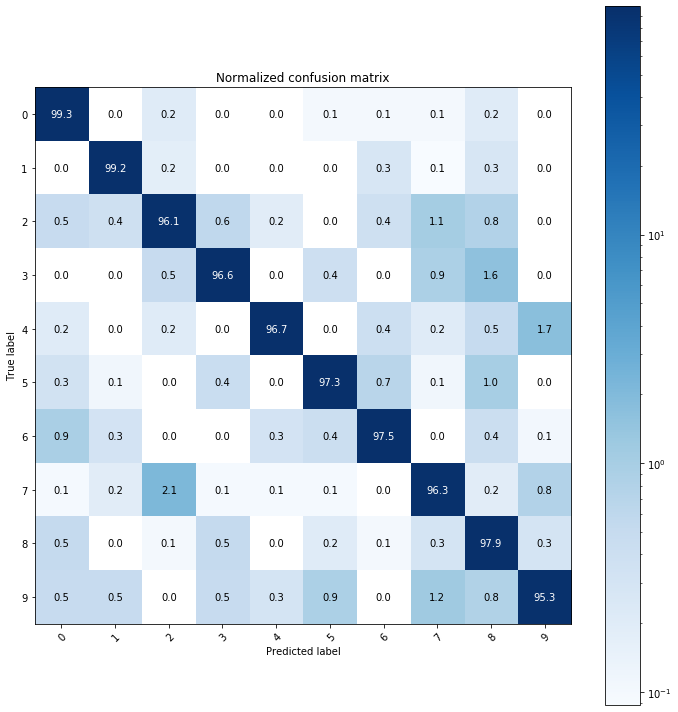

In [31]:
print(classification_report(y_test, output, digits = 3))

plot_confusion_matrix.plot_confusion_matrix(y_test, prediction, classes=class_names, normalize=True,
                      title='Normalized confusion matrix',fig_size=10)
plt.show()

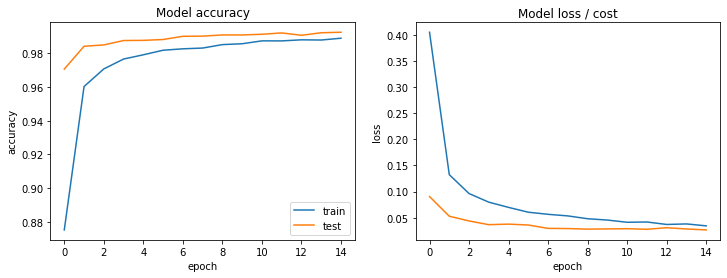

In [43]:
# summarize history for accuracy
f,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].plot(history.history['acc'], label='train')
ax[0].plot(history.history['val_acc'], label='test')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()

# summarize history for loss
ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='test')
ax[1].set_title('Model loss / cost')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[0].legend()
plt.show()
